<a href="https://colab.research.google.com/github/tesfayeaddis1/AI-ANN-Model/blob/main/maize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
splitfolders.ratio("/content/drive/MyDrive/data",
            output="splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Copying files: 545 files [00:40, 13.46 files/s]


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# -------- Transformation for the Whole Dataset for Visualization Purposes --------
data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
])

In [ ]:
train = datasets.ImageFolder(root="/content/splitted_data/train",
                              transform=train_transform)

val = datasets.ImageFolder(root="/content/splitted_data/val",
                              transform=val_transform)

test = datasets.ImageFolder(root="/content/splitted_data/test",
                              transform=test_transform)

# -------- Getting the Whole Dataset for Visualization Purposes --------
data = datasets.ImageFolder(root="/content/drive/MyDrive/data",
                              transform=data_transform)

In [ ]:
print("Dataset Labels:\n", train.class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series(dataset.targets).value_counts()
    print(f"Images per Class in {name}:")
    print(images_per_class, "\n")

Dataset Labels:
 {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3} 

Images per Class in TRAIN:
0    118
1    114
2     82
3     65
dtype: int64 

Images per Class in VALIDATION:
0    33
1    32
2    23
3    18
dtype: int64 

Images per Class in TEST:
0    18
1    18
2    13
3    11
dtype: int64 



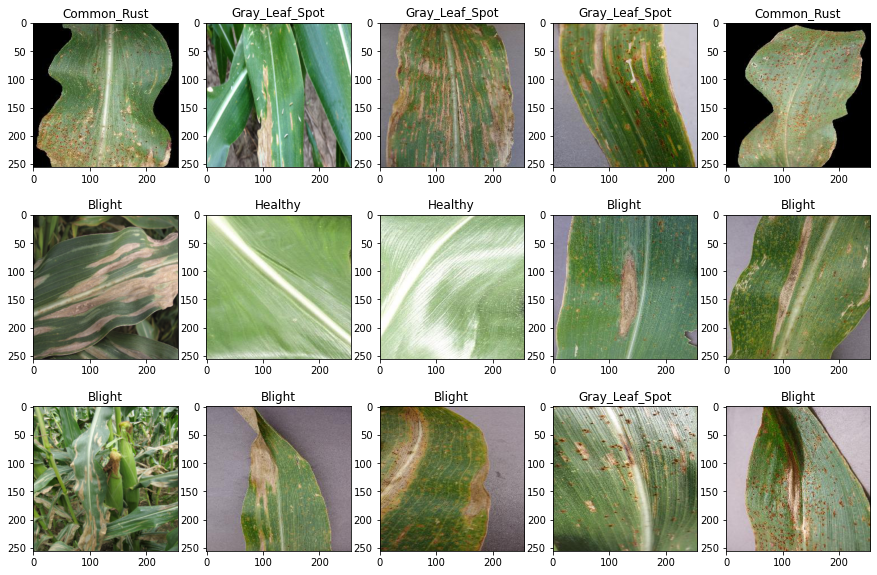

In [ ]:
labels_for_viz = {v: k for k, v in data.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(data))
    ax[i].imshow(data[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[data[sample][1]])

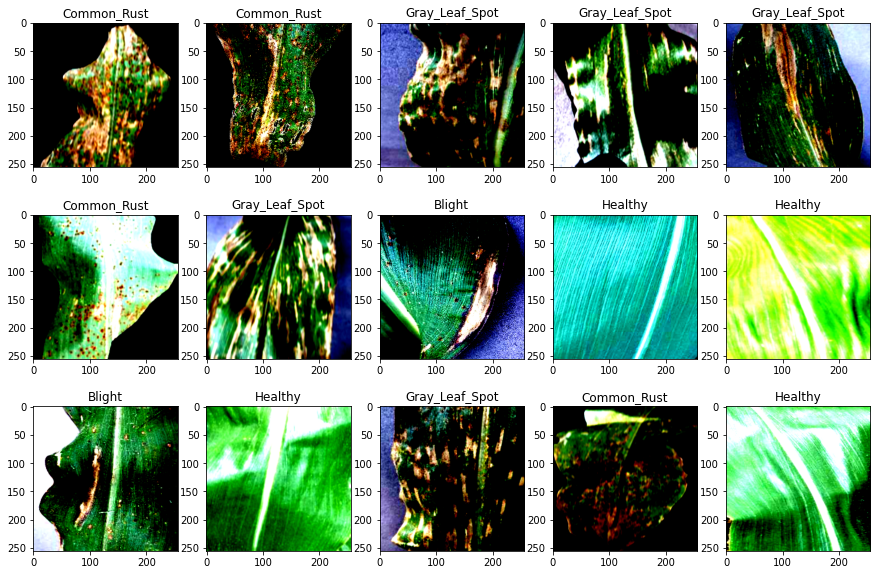

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(train))
    ax[i].imshow(train[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[train[sample][1]])

In [ ]:
train_dataloader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

val_dataloader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False)

In [ ]:
img, label = next(iter(train_dataloader))
print("Batch and Image Shape:", img.shape, "--> [batch_size, color_channels, height, width]")
print("\nLabels:", label)

Batch and Image Shape: torch.Size([32, 3, 256, 256]) --> [batch_size, color_channels, height, width]

Labels: tensor([0, 1, 2, 2, 0, 1, 1, 2, 3, 2, 1, 1, 2, 2, 1, 0, 1, 1, 0, 1, 3, 3, 2, 0,
        1, 0, 3, 0, 2, 3, 0, 1])


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=131072, out_features=32), # in_features are selected based on the output that Flatten layer yields
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=4)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=4)
model = model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10e-3)

In [ ]:
def train_and_validate_model(num_epochs):
    val_best_accuracy = 0.0
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    
    print("Training begins...")
    for epoch in range(1, num_epochs+1):
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        train_total = 0
        running_val_accuracy = 0.0
        running_val_loss = 0.0
        val_total = 0.0
        for data in train_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            optimizer.zero_grad()
            predictions = model(inputs)
            train_loss = loss_fn(predictions, outputs)
            _, train_predicted = torch.max(predictions, 1)
            running_train_accuracy += (train_predicted == outputs).sum().item()
            train_total += outputs.size(0)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()
            
        train_loss_value = running_train_loss/len(train_dataloader)
        train_loss_history.append(train_loss_value)
        train_accuracy = (100*running_train_accuracy)/train_total
        train_accuracy_history.append(train_accuracy)
        # VALIDATION LOOP
        with torch.no_grad():
            model.eval()
            for data in val_dataloader:
                inputs, outputs = data
                inputs, outputs = inputs.to(device), outputs.to(device)
                predictions = model(inputs)
                val_loss = loss_fn(predictions, outputs)
                
                _, val_predicted = torch.max(predictions, 1)
                running_val_loss += val_loss.item()
                val_total += outputs.size(0)
                running_val_accuracy += (val_predicted == outputs).sum().item()
                
        val_loss_value = running_val_loss/len(val_dataloader)
        val_loss_history.append(val_loss_value)
        val_accuracy = (100*running_val_accuracy)/val_total
        val_accuracy_history.append(val_accuracy)
        
        if val_accuracy > val_best_accuracy:
            torch.save(model.state_dict(), "model.pth")
            val_best_accuracy = val_accuracy
        
        print("Completed Epoch: ", epoch, "- Training Accuracy: %d" %train_accuracy, "- Validation Accuracy: %d" %val_accuracy, "- Training Loss: %.4f" %train_loss_value, "- Validation Loss: %.4f" %val_loss_value)
    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history

In [ ]:
def test_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(in_features=512, out_features=4)
    model = model.to(device)
    path = "model.pth"
    model.load_state_dict(torch.load(path))
    model.eval()
    
    running_accuracy = 0
    total = 0
    all_predictions = []
    
    with torch.no_grad():
        for data in test_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            outputs = outputs.to(torch.float32)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()
            accuracy = 100*running_accuracy/total
            
            all_predictions.append(list(predicted.to("cpu").numpy()))
        print("Test Accuracy: ", accuracy)
    return np.hstack(all_predictions) # returns a flattened array of batches of predictions

In [ ]:
EPOCHS = 15
train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_and_validate_model(EPOCHS)
print("Training finished...\n")
all_preds = test_model()

Training begins...
Completed Epoch:  1 - Training Accuracy: 55 - Validation Accuracy: 76 - Training Loss: 1.0568 - Validation Loss: 0.6953
Completed Epoch:  2 - Training Accuracy: 65 - Validation Accuracy: 79 - Training Loss: 0.8953 - Validation Loss: 0.5074
Completed Epoch:  3 - Training Accuracy: 75 - Validation Accuracy: 72 - Training Loss: 0.5627 - Validation Loss: 0.4933
Completed Epoch:  4 - Training Accuracy: 75 - Validation Accuracy: 72 - Training Loss: 0.4899 - Validation Loss: 0.5549
Completed Epoch:  5 - Training Accuracy: 82 - Validation Accuracy: 83 - Training Loss: 0.4495 - Validation Loss: 0.3191
Completed Epoch:  6 - Training Accuracy: 81 - Validation Accuracy: 87 - Training Loss: 0.4796 - Validation Loss: 0.4494
Completed Epoch:  7 - Training Accuracy: 84 - Validation Accuracy: 73 - Training Loss: 0.3757 - Validation Loss: 0.5221
Completed Epoch:  8 - Training Accuracy: 83 - Validation Accuracy: 85 - Training Loss: 0.4397 - Validation Loss: 0.3027
Completed Epoch:  9 -

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy:  91.66666666666667


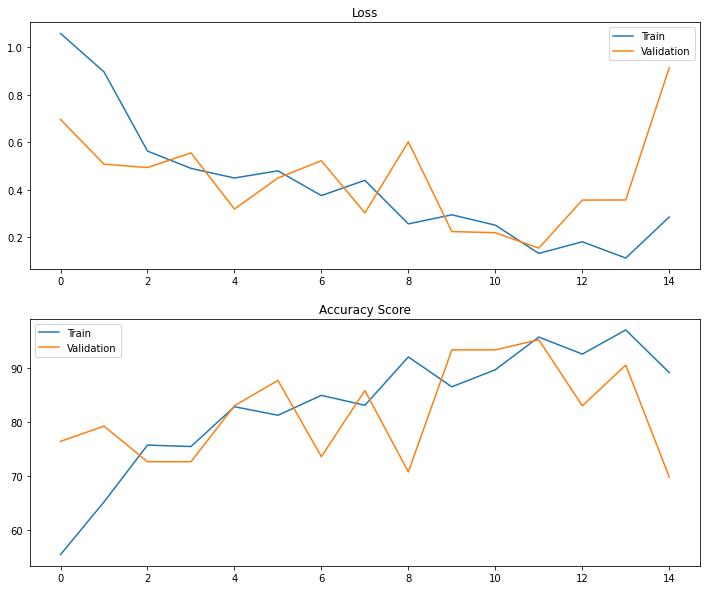

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax = ax.flatten()

ax[0].plot(train_loss_history, label="Train")
ax[0].plot(val_loss_history, label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(train_accuracy_history, label="Train")
ax[1].plot(val_accuracy_history, label="Validation")
ax[1].title.set_text("Accuracy Score")
ax[1].legend()

plt.show()

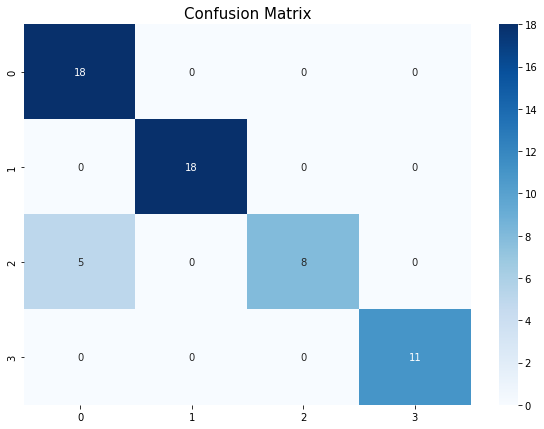

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test.targets, all_preds), cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix", size=15)
plt.show()

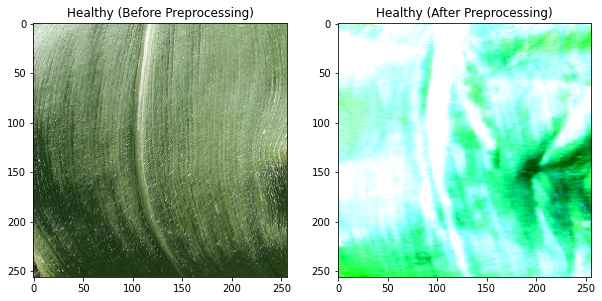

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.flatten()

ax[0].imshow(data[-1][0].permute(1, 2, 0))
ax[0].title.set_text(f"{labels_for_viz[data[-1][1]]} (Before Preprocessing)")

ax[1].imshow(test[-1][0].permute(1, 2, 0))
ax[1].title.set_text(f"{labels_for_viz[test[-1][1]]} (After Preprocessing)")
plt.show()

In [ ]:
single_prediction = model.forward((test[-1][0]).to(device).unsqueeze(0))
single_prediction

tensor([[-2.4434, -7.0289, -2.7764, 11.1381]], grad_fn=<AddmmBackward0>)

In [ ]:
single_prediction = int(torch.max(single_prediction, 1)[1])
print("Predicted Class:", labels_for_viz[single_prediction])

Predicted Class: Healthy
